# GCode Parser for PrusaSlicer

- ;TYPE:Perimeter
- ;TYPE:External perimeter
- ;TYPE:Overhang perimeter

- ;TYPE:Internal infill
- ;TYPE:Solid infill
- ;TYPE:Top solid infill
- ;TYPE:Bridge infill

- ;TYPE:Support material
- ;TYPE:Support material interface

- ;TYPE:Skirt/Brim
- ;TYPE:Wipe tower
- ;TYPE:Custom

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [2]:
line = ";LAYER_Z_HEIGHT=11.7"
line = line.rstrip()
layer_height = 0
bits = line.split(';',1)
print(bits[1][:15])

print('-----')
layer_height = float(bits[1][15:])
print('layer_height= ',layer_height)
print('-----')


print(line)
print(bits)

if(len(bits)>1):
    if (bits[1][:20] == "TYPE:Internal infill" or bits[1][:17] == "TYPE:Solid infill" or  bits[1][:21] == "TYPE:Top solid infill" or  bits[1][:18] == "TYPE:Bridge infill"):
        #print(bits[1][:14])
        print('fill')
    else:
        print('else')

LAYER_Z_HEIGHT=
-----
layer_height=  11.7
-----
;LAYER_Z_HEIGHT=11.7
['', 'LAYER_Z_HEIGHT=11.7']
else


In [3]:
class Segment:
    def __init__(self,move_type,coords,layer_index,shell,fill,support,other):
        self.type = move_type
        self.coords = coords
        self.layer_index = layer_index
        self.shell = shell
        self.fill = fill
        self.support = support
        self.other = other
        self.style = None

In [4]:
class Parser:

    def __init__(self):
        self.relative = {"X":0.0,"Y":0.0,"F":0.0,"E":0.0, "z_height":0.0}
        self.isRelative = False
        self.segments = []
        self.layer_number = 0
        self.z_height = 0.0
        self.layers = []
        self.shell = 0
        self.fill = 0
        self.support = 0
        self.other = 0

    def parseFile(self,path):
        with open(path, 'r') as f:
            self.lineNb = 0
            for line in f:
                self.lineNb += 1
                self.line = line.rstrip()
                self.parseLine()

    def parseLine(self):
        bits = self.line.split(';',1)
        if(len(bits)>1):
            if (bits[1][:12] == 'LAYER_CHANGE'):
                self.layer_number += 1
                #self.z_height += 0.3

        if(len(bits)>1):
            if (bits[1][:15] == 'LAYER_Z_HEIGHT='):
                self.z_height = float(bits[1][15:])

        if(len(bits)>1):
            if (bits[1][:20] == "TYPE:Internal infill" or
                  bits[1][:17] == "TYPE:Solid infill" or
                  bits[1][:21] == "TYPE:Top solid infill" or
                  bits[1][:18] == "TYPE:Bridge infill"):
                self.shell = 0
                self.fill = 1
                self.support = 0
                self.other = 0
            elif (bits[1][:14] == "TYPE:Perimeter" or
                bits[1][:23] == "TYPE:External perimeter" or
                bits[1][:23] == "TYPE:Overhang perimeter"):
                self.shell = 1
                self.fill = 0
                self.support = 0
                self.other = 0

            elif (bits[1][:21] == "TYPE:Support material" or
                  bits[1][:31] == "TYPE:Support material interface"):
                self.shell = 0
                self.fill = 0
                self.support = 1
                self.other = 0
            '''else:
                self.shell = 0
                self.fill = 0
                self.support = 0
                self.other = 1'''

        command = bits[0].strip()
        comm = command.split(None, 1)
        code = comm[0] if (len(comm)>0) else None # G
        args = comm[1] if (len(comm)>1) else None # XYEF

        if code:
            if hasattr(self, "parse_"+code):
                getattr(self, "parse_"+code)(args)
                #print("code= ", code, ": args= ", args)
            return code,args

    def parseArgs(self, args):
        dic = {}
        if args:
            bits = args.split()
            for bit in bits:
                letter = bit[0]
                try:
                    coord = float(bit[1:])
                except ValueError:
                    coord = 1
                dic[letter] = coord
        return dic

    def parse_G0(self, args, move_type="G0"):
        self.do_G0_G1(self.parseArgs(args), move_type)

    def parse_G1(self, args, move_type="G1"):
        self.do_G0_G1(self.parseArgs(args), move_type)

    def do_G0_G1(self,args,move_type):
        coords = dict(self.relative)
        for axis in args.keys():
            if axis in coords:
                if self.isRelative:
                    coords[axis] += args[axis]
                else:
                    coords[axis] = args[axis]
        # build segment
        absolute = {"X": coords["X"],"Y": coords["Y"],"z_height": self.z_height}
        if "E" not in args : #"E" in coords:
            absolute["E"] = 0
        else:
            absolute["E"] = args["E"]

        seg = Segment(move_type,absolute,self.layer_number,self.shell,self.fill,self.support,self.other)

        if (seg.coords['X'] != self.relative['X'] or
            seg.coords['Y'] != self.relative['Y']):
            self.segments.append(seg)
        self.relative = coords
        return self.relative

    def classifySegments(self):
        coords = {"X":0.0,"Y":0.0,"Z":0.0,"F":0.0,"E":0.0}
        current_layer = 0
        layer = []

        for i, seg in enumerate(self.segments):
            # default style is travel (move, no extrusion)
            style = "travel"

            # some horizontal movement, and positive extruder movement: extrusion
            if (((seg.coords["X"] != coords["X"])
                    or (seg.coords["Y"] != coords["Y"])
                    or (seg.coords["z_height"] != coords["Z"])) and (seg.coords["E"]>0)): #!= coords["E"]
                style = "extrude"

            if i==len(self.segments)-1:
                layer.append(seg)
                current_layer += 1
                seg.style = style
                seg.layer_index = current_layer
                self.layers.append(layer)
                print('**Segment classification complete**')
                break

            if (self.segments[i].layer_index != current_layer):
                self.layers.append(layer)
                layer = []
                current_layer+=1

            # set style and layer in segment
            seg.style = style
            coords = seg.coords
            layer.append(seg)

In [6]:
parser = Parser()
parser.parseFile('/content/drive/MyDrive/Colab Notebooks/cyberpunk_robot_with_support_0.4n_0.3mm_PLA_MK3SMMU2S_6h4m.gcode')

parser.classifySegments()
print(len(parser.segments))
print(len(parser.layers))

print(parser.layer_number)
print(parser.z_height)

**Segment classification complete**
513310
769
768
80.0


In [7]:
# just for ref

LN = 4 # layer number
sn = 46 # segment number
print(len(parser.layers[LN])) # segments in the layer
print(parser.layers[LN][sn]) # one segment
print(parser.layers[LN][sn].coords)
print(parser.layers[LN][sn].coords['X'])
print(parser.layers[LN][sn].style)
print(parser.layers[LN][sn].type)
print(parser.layers[LN][sn].shell)
print(parser.layers[LN][sn].fill)
print(parser.layers[LN][sn].support)
print(parser.layers[LN][sn].other)
print(parser.layers[LN][sn].layer_index)

827
{'X': 138.32, 'Y': 82.931, 'z_height': 0.5, 'E': 0.01342}
138.32
extrude
G1
1
0
0
0
4


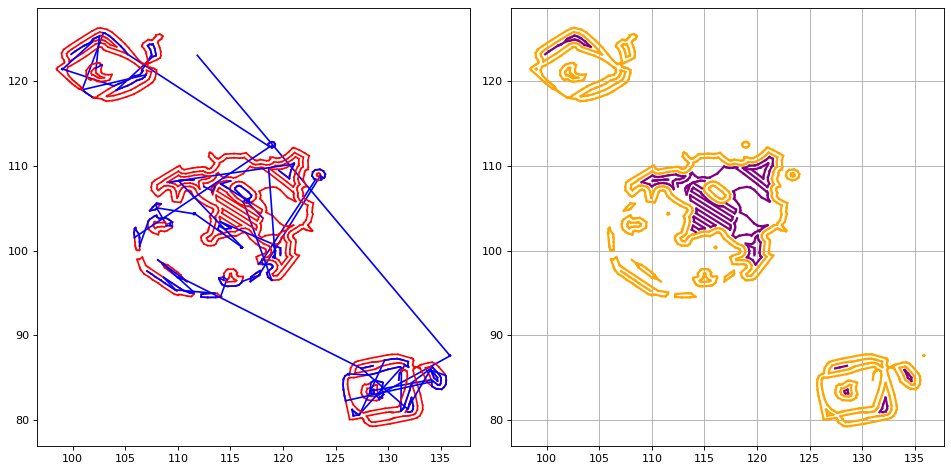

1782


In [8]:
LN = 534 # layers start from 1

fig = plt.figure(figsize=(12,6), dpi=80)
plt.subplot(121)
for i in range(1,len(parser.layers[LN])):
    if(parser.layers[LN][i].style == 'extrude'):
        plt.plot([parser.layers[LN][i].coords['X'],parser.layers[LN][i-1].coords['X']],
             [parser.layers[LN][i].coords['Y'],parser.layers[LN][i-1].coords['Y']],c='r')
    else:
        plt.plot([parser.layers[LN][i].coords['X'],parser.layers[LN][i-1].coords['X']],
             [parser.layers[LN][i].coords['Y'],parser.layers[LN][i-1].coords['Y']],c='b')

plt.subplot(122)
for i in range(len(parser.layers[LN])):
    if(parser.layers[LN][i].style == 'extrude' and parser.layers[LN][i].shell == 1):
        plt.plot([parser.layers[LN][i].coords['X'],parser.layers[LN][i-1].coords['X']],
             [parser.layers[LN][i].coords['Y'],parser.layers[LN][i-1].coords['Y']],
                 c='orange',linewidth=2,linestyle='-')
    if(parser.layers[LN][i].style == 'extrude' and parser.layers[LN][i].fill == 1):
        plt.plot([parser.layers[LN][i].coords['X'],parser.layers[LN][i-1].coords['X']],
             [parser.layers[LN][i].coords['Y'],parser.layers[LN][i-1].coords['Y']],
                 c='purple',linewidth=2,linestyle='-')
    if(parser.layers[LN][i].style == 'extrude' and parser.layers[LN][i].support == 1):
        plt.plot([parser.layers[LN][i].coords['X'],parser.layers[LN][i-1].coords['X']],
             [parser.layers[LN][i].coords['Y'],parser.layers[LN][i-1].coords['Y']],
                 c='lime',linewidth=2,linestyle='-')


plt.grid()
plt.tight_layout()
plt.show()

print(i)
# blue - travel
# red - extrude
# lime - shell

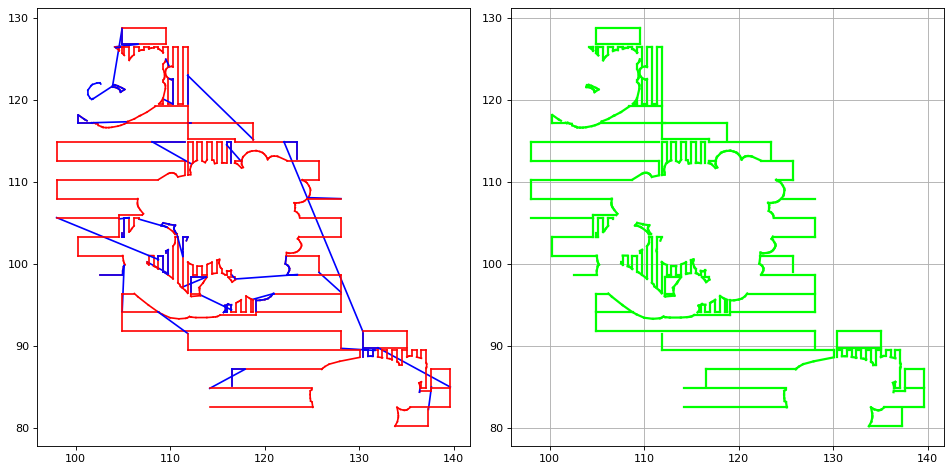

694


In [9]:
LN = 535 # layers start from 1

fig = plt.figure(figsize=(12,6), dpi=80)
plt.subplot(121)
for i in range(1,len(parser.layers[LN])):
    if(parser.layers[LN][i].style == 'extrude'):
        plt.plot([parser.layers[LN][i].coords['X'],parser.layers[LN][i-1].coords['X']],
             [parser.layers[LN][i].coords['Y'],parser.layers[LN][i-1].coords['Y']],c='r')
    else:
        plt.plot([parser.layers[LN][i].coords['X'],parser.layers[LN][i-1].coords['X']],
             [parser.layers[LN][i].coords['Y'],parser.layers[LN][i-1].coords['Y']],c='b')

plt.subplot(122)
for i in range(len(parser.layers[LN])):
    if(parser.layers[LN][i].style == 'extrude' and parser.layers[LN][i].shell == 1):
        plt.plot([parser.layers[LN][i].coords['X'],parser.layers[LN][i-1].coords['X']],
             [parser.layers[LN][i].coords['Y'],parser.layers[LN][i-1].coords['Y']],
                 c='orange',linewidth=2,linestyle='-')
    if(parser.layers[LN][i].style == 'extrude' and parser.layers[LN][i].fill == 1):
        plt.plot([parser.layers[LN][i].coords['X'],parser.layers[LN][i-1].coords['X']],
             [parser.layers[LN][i].coords['Y'],parser.layers[LN][i-1].coords['Y']],
                 c='purple',linewidth=2,linestyle='-')
    if(parser.layers[LN][i].style == 'extrude' and parser.layers[LN][i].support == 1):
        plt.plot([parser.layers[LN][i].coords['X'],parser.layers[LN][i-1].coords['X']],
             [parser.layers[LN][i].coords['Y'],parser.layers[LN][i-1].coords['Y']],
                 c='lime',linewidth=2,linestyle='-')


plt.grid()
plt.tight_layout()
plt.show()

print(i)
# blue - travel
# red - extrude
# lime - shell

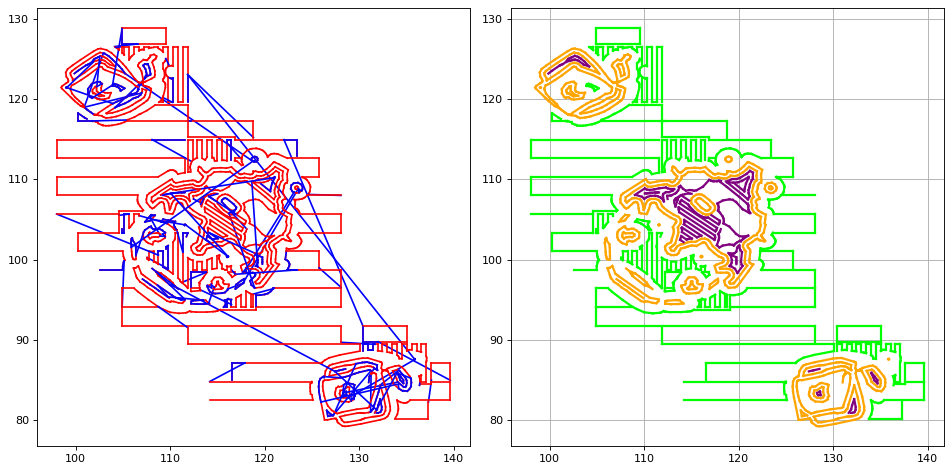

694


In [10]:
LN = 534 # layers start from 1

fig = plt.figure(figsize=(12,6), dpi=80)
plt.subplot(121)
for i in range(1,len(parser.layers[LN])):
    if(parser.layers[LN][i].style == 'extrude'):
        plt.plot([parser.layers[LN][i].coords['X'],parser.layers[LN][i-1].coords['X']],
             [parser.layers[LN][i].coords['Y'],parser.layers[LN][i-1].coords['Y']],c='r')
    else:
        plt.plot([parser.layers[LN][i].coords['X'],parser.layers[LN][i-1].coords['X']],
             [parser.layers[LN][i].coords['Y'],parser.layers[LN][i-1].coords['Y']],c='b')

for i in range(1,len(parser.layers[LN+1])):
    if(parser.layers[LN+1][i].style == 'extrude'):
        plt.plot([parser.layers[LN+1][i].coords['X'],parser.layers[LN+1][i-1].coords['X']],
             [parser.layers[LN+1][i].coords['Y'],parser.layers[LN+1][i-1].coords['Y']],c='r')
    else:
        plt.plot([parser.layers[LN+1][i].coords['X'],parser.layers[LN+1][i-1].coords['X']],
             [parser.layers[LN+1][i].coords['Y'],parser.layers[LN+1][i-1].coords['Y']],c='b')

plt.subplot(122)
for i in range(len(parser.layers[LN])):
    if(parser.layers[LN][i].style == 'extrude' and parser.layers[LN][i].shell == 1):
        plt.plot([parser.layers[LN][i].coords['X'],parser.layers[LN][i-1].coords['X']],
             [parser.layers[LN][i].coords['Y'],parser.layers[LN][i-1].coords['Y']],
                 c='orange',linewidth=2,linestyle='-')
    if(parser.layers[LN][i].style == 'extrude' and parser.layers[LN][i].fill == 1):
        plt.plot([parser.layers[LN][i].coords['X'],parser.layers[LN][i-1].coords['X']],
             [parser.layers[LN][i].coords['Y'],parser.layers[LN][i-1].coords['Y']],
                 c='purple',linewidth=2,linestyle='-')
    if(parser.layers[LN][i].style == 'extrude' and parser.layers[LN][i].support == 1):
        plt.plot([parser.layers[LN][i].coords['X'],parser.layers[LN][i-1].coords['X']],
             [parser.layers[LN][i].coords['Y'],parser.layers[LN][i-1].coords['Y']],
                 c='lime',linewidth=2,linestyle='-')

for i in range(len(parser.layers[LN+1])):
    if(parser.layers[LN+1][i].style == 'extrude' and parser.layers[LN+1][i].shell == 1):
        plt.plot([parser.layers[LN+1][i].coords['X'],parser.layers[LN+1][i-1].coords['X']],
             [parser.layers[LN+1][i].coords['Y'],parser.layers[LN+1][i-1].coords['Y']],
                 c='orange',linewidth=2,linestyle='-')
    if(parser.layers[LN+1][i].style == 'extrude' and parser.layers[LN+1][i].fill == 1):
        plt.plot([parser.layers[LN+1][i].coords['X'],parser.layers[LN][i-1].coords['X']],
             [parser.layers[LN+1][i].coords['Y'],parser.layers[LN+1][i-1].coords['Y']],
                 c='purple',linewidth=2,linestyle='-')
    if(parser.layers[LN+1][i].style == 'extrude' and parser.layers[LN+1][i].support == 1):
        plt.plot([parser.layers[LN+1][i].coords['X'],parser.layers[LN+1][i-1].coords['X']],
             [parser.layers[LN+1][i].coords['Y'],parser.layers[LN+1][i-1].coords['Y']],
                 c='lime',linewidth=2,linestyle='-')


plt.grid()
plt.tight_layout()
plt.show()

print(i)
# blue - travel
# red - extrude
# lime - shell

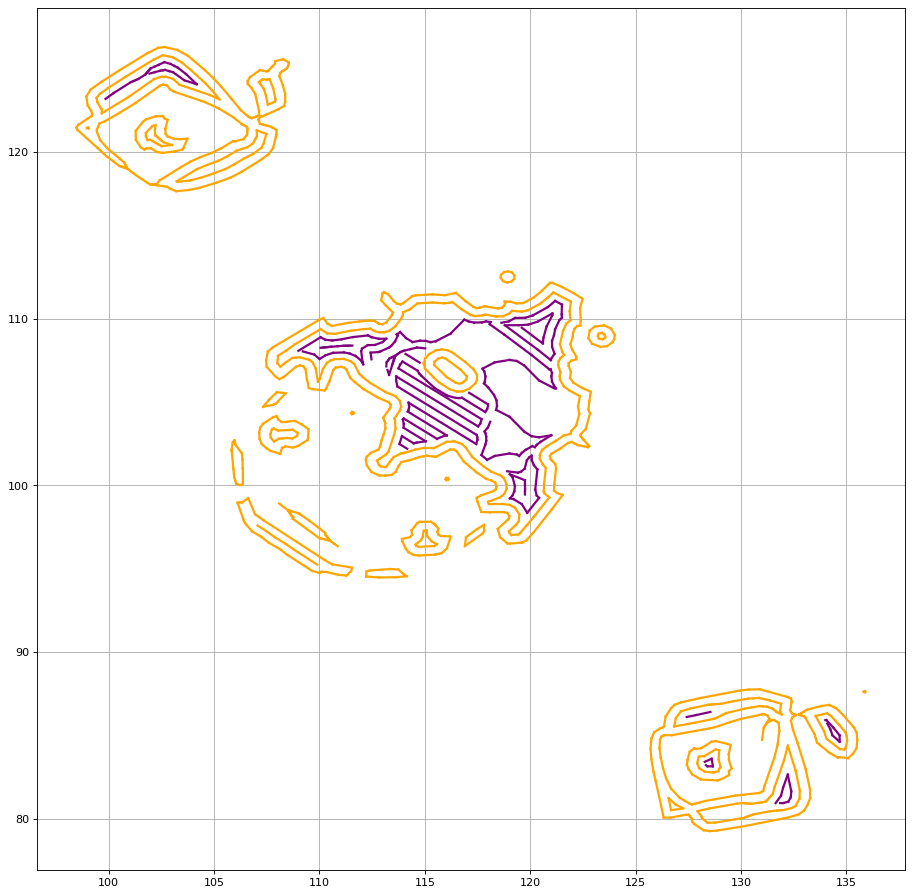

In [11]:
fig = plt.figure(figsize=(14,14), dpi=80)
for i in range(1,len(parser.layers[LN])):
    if(parser.layers[LN][i].style == 'extrude' and parser.layers[LN][i].shell == 1):
        plt.plot([parser.layers[LN][i].coords['X'],parser.layers[LN][i-1].coords['X']],
             [parser.layers[LN][i].coords['Y'],parser.layers[LN][i-1].coords['Y']],
                 c='orange',linewidth=2,linestyle='-')
    if(parser.layers[LN][i].style == 'extrude' and parser.layers[LN][i].fill == 1):
        plt.plot([parser.layers[LN][i].coords['X'],parser.layers[LN][i-1].coords['X']],
             [parser.layers[LN][i].coords['Y'],parser.layers[LN][i-1].coords['Y']],
                 c='purple',linewidth=2,linestyle='-')
    if(parser.layers[LN][i].style == 'extrude' and parser.layers[LN][i].support == 1):
        plt.plot([parser.layers[LN][i].coords['X'],parser.layers[LN][i-1].coords['X']],
             [parser.layers[LN][i].coords['Y'],parser.layers[LN][i-1].coords['Y']],
                 c='lime',linewidth=2,linestyle='-')
plt.grid()
plt.show()

In [12]:
len(parser.layers[LN])

1783

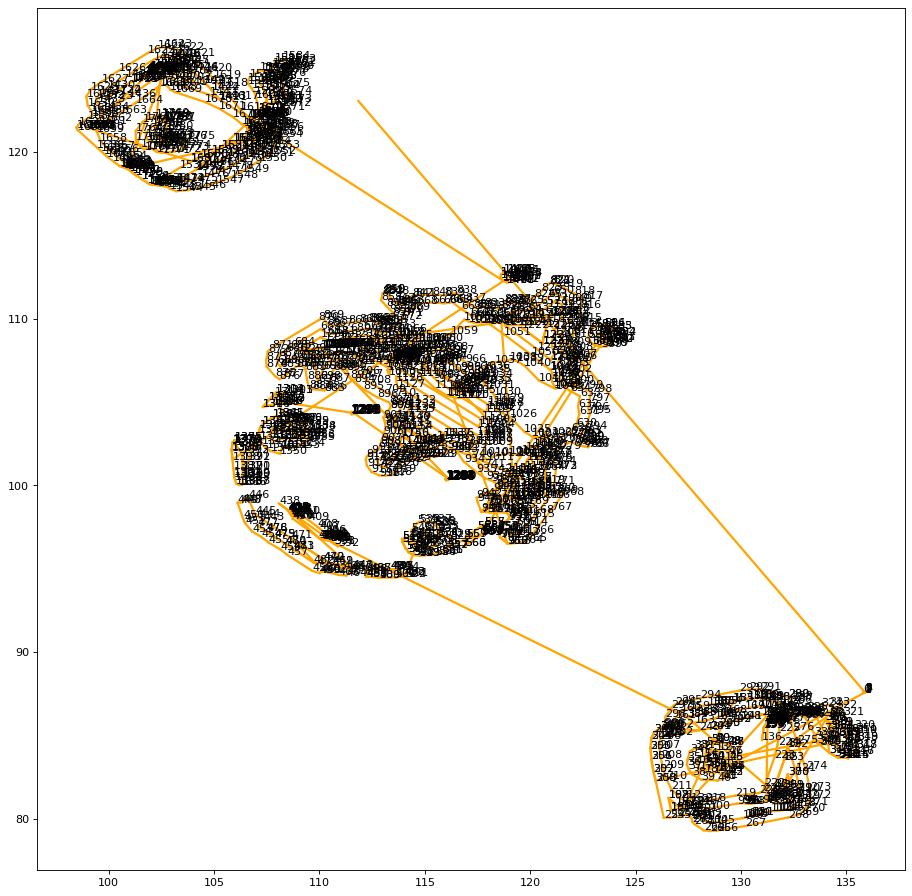

In [13]:
fig = plt.figure(figsize=(14,14), dpi=80)
for i in range(1,len(parser.layers[LN])):
    plt.plot([parser.layers[LN][i].coords['X'],parser.layers[LN][i-1].coords['X']],
             [parser.layers[LN][i].coords['Y'],parser.layers[LN][i-1].coords['Y']],
                 c='orange',linewidth=2,linestyle='-')
    plt.text(parser.layers[LN][i].coords['X'], parser.layers[LN][i].coords['Y'], i)
plt.show()

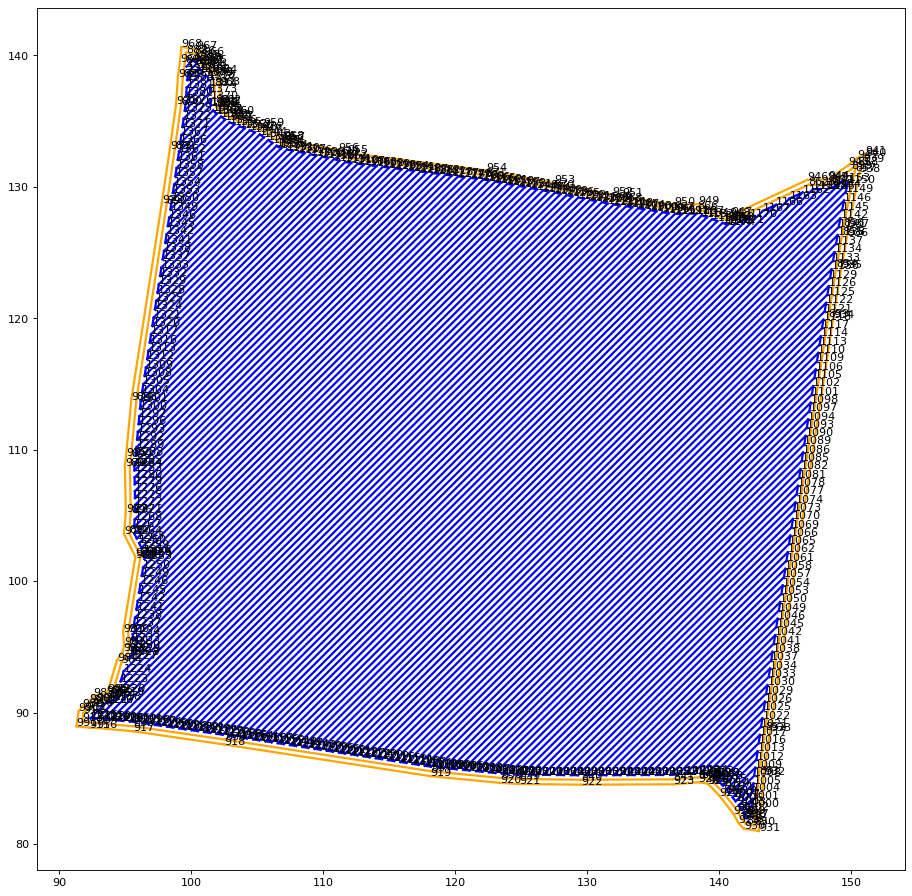

In [14]:
LN = 1
fig = plt.figure(figsize=(14,14), dpi=80)
for i in range(1,len(parser.layers[LN])):
  if(parser.layers[LN][i].style == 'extrude'):
    if(parser.layers[LN][i].shell == 1):
      plt.plot([parser.layers[LN][i].coords['X'],parser.layers[LN][i-1].coords['X']],
             [parser.layers[LN][i].coords['Y'],parser.layers[LN][i-1].coords['Y']],
                 c='orange',linewidth=2,linestyle='-')
      plt.text(parser.layers[LN][i].coords['X'], parser.layers[LN][i].coords['Y'], i)
    elif(parser.layers[LN][i].fill == 1):
      plt.plot([parser.layers[LN][i].coords['X'],parser.layers[LN][i-1].coords['X']],
             [parser.layers[LN][i].coords['Y'],parser.layers[LN][i-1].coords['Y']],
                 c='blue',linewidth=2,linestyle='-')
      plt.text(parser.layers[LN][i].coords['X'], parser.layers[LN][i].coords['Y'], i)
plt.show()

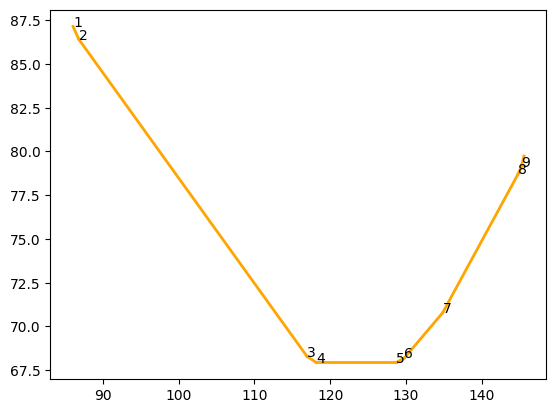

In [15]:
for i in range(1,10):
    plt.plot([parser.layers[LN][i].coords['X'],parser.layers[LN][i-1].coords['X']],
             [parser.layers[LN][i].coords['Y'],parser.layers[LN][i-1].coords['Y']],
                 c='orange',linewidth=2,linestyle='-')
    plt.text(parser.layers[LN][i-1].coords['X'], parser.layers[LN][i-1].coords['Y'], i)

In [16]:
print(parser.layers[LN][-1].type)
print(parser.layers[LN][2].coords)
print(parser.layers[LN][2].layer_index)
print(parser.layers[LN][2].shell)
print(parser.layers[LN][2].fill)
print(parser.layers[LN][2].support)
print(parser.layers[LN][2].other)
print(parser.layers[LN][2].style)

G1
{'X': 116.948, 'Y': 68.285, 'z_height': 0.2, 'E': 1.10174}
1
0
0
0
0
extrude


In [17]:
LN = 4
print(len(parser.layers[LN]))

for i in range(len(parser.layers[LN])):
  line_type = ""
  if(parser.layers[LN][i].shell == 1):
    line_type = "shell"
  elif(parser.layers[LN][i].fill == 1):
    line_type = "fill"
  else:
    line_type = "else"

  print(i,':',parser.layers[LN][i].layer_index,
        parser.layers[LN][i].style,
        parser.layers[LN][i].type,
        parser.layers[LN][i].coords,
        line_type)

827
0 : 4 travel G1 {'X': 132.7, 'Y': 79.868, 'z_height': 0.5, 'E': -0.02217} else
1 : 4 travel G1 {'X': 132.7, 'Y': 77.9, 'z_height': 0.5, 'E': -0.45442} else
2 : 4 travel G1 {'X': 131.299, 'Y': 77.9, 'z_height': 0.5, 'E': -0.32341} else
3 : 4 travel G1 {'X': 136.134, 'Y': 71.83, 'z_height': 0.5, 'E': 0} else
4 : 4 extrude G1 {'X': 144.777, 'Y': 78.715, 'z_height': 0.5, 'E': 0.49013} else
5 : 4 extrude G1 {'X': 145.18, 'Y': 79.124, 'z_height': 0.5, 'E': 0.02547} else
6 : 4 extrude G1 {'X': 145.539, 'Y': 79.733, 'z_height': 0.5, 'E': 0.03136} else
7 : 4 extrude G1 {'X': 145.744, 'Y': 80.396, 'z_height': 0.5, 'E': 0.03078} else
8 : 4 extrude G1 {'X': 153.747, 'Y': 132.45, 'z_height': 0.5, 'E': 2.33597} else
9 : 4 extrude G1 {'X': 153.729, 'Y': 133.347, 'z_height': 0.5, 'E': 0.03979} else
10 : 4 extrude G1 {'X': 153.163, 'Y': 134.559, 'z_height': 0.5, 'E': 0.05933} else
11 : 4 extrude G1 {'X': 150.693, 'Y': 137.362, 'z_height': 0.5, 'E': 0.16571} else
12 : 4 extrude G1 {'X': 149.939, 'Y'

In [18]:
def segments_to_meshdata(segments):#edges only on extrusion
    segs = segments
    verts=[]
    edges=[]
    props = []

    del_offset=0 #to travel segs in a row, one gets deleted, need to keep track of index for edges
    for i in range(len(segs)):
        print(segs[i].coords)
        #props.append(0)
        if i>=len(segs)-1:
            if segs[i].style == 'extrude':
                verts.append([segs[i].coords['X'],segs[i].coords['Y'],segs[i].coords['z_height'] ])
            break


        #start of extrusion for first time
        if segs[i].style == 'travel' and segs[i+1].style == 'extrude':
            verts.append([segs[i].coords['X'],segs[i].coords['Y'],segs[i].coords['z_height'] ])
            verts.append([segs[i+1].coords['X'],segs[i+1].coords['Y'],segs[i+1].coords['z_height'] ])
            edges.append([i-del_offset,(i-del_offset)+1])

            if segs[i+1].fill == 1:
                props.append('fill')
            elif segs[i+1].shell == 1:
                props.append('shell')
            elif segs[i+1].support == 1:
                props.append('support')
            else:
                props.append('NA')



        #mitte, current and next are extrusion, only add next, current is already in vert list
        if segs[i].style == 'extrude' and segs[i+1].style == 'extrude':
            verts.append([segs[i+1].coords['X'],segs[i+1].coords['Y'],segs[i+1].coords['z_height'] ])
            edges.append([i-del_offset,(i-del_offset)+1])

            if segs[i+1].fill == 1:
                props.append('fill')
            elif segs[i+1].shell == 1:
                props.append('shell')
            elif segs[i+1].support == 1:
                props.append('support')
            else:
                props.append('NA')



        if segs[i].style == 'travel' and segs[i+1].style == 'travel':
            del_offset+=1

    return verts, edges, props

In [19]:
verts, edges, props = segments_to_meshdata(parser.layers[4]) # LN = 80 => LAYER:79 in gcode

# props (properties) and edges have to have the same length

print(np.shape(verts))
print(np.shape(edges))
print(np.shape(props))

{'X': 132.7, 'Y': 79.868, 'z_height': 0.5, 'E': -0.02217}
{'X': 132.7, 'Y': 77.9, 'z_height': 0.5, 'E': -0.45442}
{'X': 131.299, 'Y': 77.9, 'z_height': 0.5, 'E': -0.32341}
{'X': 136.134, 'Y': 71.83, 'z_height': 0.5, 'E': 0}
{'X': 144.777, 'Y': 78.715, 'z_height': 0.5, 'E': 0.49013}
{'X': 145.18, 'Y': 79.124, 'z_height': 0.5, 'E': 0.02547}
{'X': 145.539, 'Y': 79.733, 'z_height': 0.5, 'E': 0.03136}
{'X': 145.744, 'Y': 80.396, 'z_height': 0.5, 'E': 0.03078}
{'X': 153.747, 'Y': 132.45, 'z_height': 0.5, 'E': 2.33597}
{'X': 153.729, 'Y': 133.347, 'z_height': 0.5, 'E': 0.03979}
{'X': 153.163, 'Y': 134.559, 'z_height': 0.5, 'E': 0.05933}
{'X': 150.693, 'Y': 137.362, 'z_height': 0.5, 'E': 0.16571}
{'X': 149.939, 'Y': 137.933, 'z_height': 0.5, 'E': 0.04195}
{'X': 138.993, 'Y': 143.197, 'z_height': 0.5, 'E': 0.53873}
{'X': 138.299, 'Y': 143.407, 'z_height': 0.5, 'E': 0.03216}
{'X': 121.754, 'Y': 145.747, 'z_height': 0.5, 'E': 0.74115}
{'X': 113.748, 'Y': 145.744, 'z_height': 0.5, 'E': 0.3551}
{'X

In [20]:
# find edges that are related to fill

edges_fill=[]
for i in range(len(props)):
    if(props[i]=='fill'):
        edges_fill.append(edges[i])
print(edges_fill)


# find vertices relayed to fill
flat_list = [item for sublist in edges_fill for item in sublist]
flat_list = list(set(flat_list))

verts_fill = []
for i in range(len(flat_list)):
    verts_fill.append(verts[flat_list[i]])

print(verts_fill)

[[189, 190], [190, 191], [191, 192], [192, 193], [193, 194], [194, 195], [195, 196], [196, 197], [197, 198], [198, 199], [199, 200], [200, 201], [201, 202], [202, 203], [203, 204], [204, 205], [205, 206], [206, 207], [207, 208], [208, 209], [209, 210], [210, 211], [211, 212], [212, 213], [213, 214], [214, 215], [215, 216], [216, 217], [217, 218], [218, 219], [219, 220], [220, 221], [221, 222], [222, 223], [223, 224], [224, 225], [225, 226], [226, 227], [227, 228], [228, 229], [229, 230], [231, 232], [232, 233], [233, 234], [234, 235], [235, 236], [236, 237], [237, 238], [238, 239], [240, 241], [241, 242], [242, 243], [244, 245], [245, 246], [246, 247], [247, 248], [248, 249], [249, 250], [250, 251], [251, 252], [252, 253], [253, 254], [254, 255], [255, 256], [256, 257], [257, 258], [258, 259], [259, 260], [260, 261], [261, 262], [262, 263], [263, 264], [264, 265], [265, 266], [266, 267], [267, 268], [268, 269], [269, 270], [270, 271], [271, 272], [272, 273], [273, 274], [274, 275], [27